In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

### Data

In [2]:
### Model inputs (Black-Scholes) ###
S0 = 0.01 # spot rate
r = 0.1 # drift
sigma = 0.1 # volatility


### Simulation inputs ###
stepsPerYear = 12 # monthly
T = 5
nSteps = stepsPerYear * T
nPaths = 1000
paths = list(range(nPaths))

simulationGrid = np.linspace(0, T, nSteps + 1) # simulation/valuation grid (evenly spaced)
print("Simulation Grid:\n", simulationGrid, "\n")


## Contract inputs ###

# Swap
isCallable = False
exerciseGrid = []
fixedRate = 0.0133
notional = 100_000
maturity = T # maturity
assert maturity <= T, "Trade maturity can't exceed the final simulation date"
freq = 1/4 # 3 months
cfGrid = [t for t in simulationGrid if t % freq == 0\
          and t != 0 and t <= maturity]



print("Cashflow Grid:\n", cfGrid, "\n")
contract = "Swap"


# # American Option
# isCallable = True
# maturity = 2
# exerciseGrid = [t for t in simulationGrid if t <= maturity]
# print("Exercise Grid:\n", exerciseGrid, "\n")
# contract = "American Put"
# K = S0
# cfGrid = []


### Regression inputs ###
RegressOnDateNowCashflows = False
polynomialOrder = 2
algorithm = "LS" # or "TvR"
observables = ["S"]
valuationGrid = [t for t in simulationGrid if t <= maturity]
print("Valuation Grid:\n", valuationGrid, "\n")


yearlyGrid = list(range(int(maturity)))

Simulation Grid:
 [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.         2.08333333 2.16666667 2.25       2.33333333 2.41666667
 2.5        2.58333333 2.66666667 2.75       2.83333333 2.91666667
 3.         3.08333333 3.16666667 3.25       3.33333333 3.41666667
 3.5        3.58333333 3.66666667 3.75       3.83333333 3.91666667
 4.         4.08333333 4.16666667 4.25       4.33333333 4.41666667
 4.5        4.58333333 4.66666667 4.75       4.83333333 4.91666667
 5.        ] 

Cashflow Grid:
 [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0] 

Valuation Grid:
 [0.0, 0.08333333333333333, 0.16666666666666666, 0.25, 0.3333333333333333, 0.41666666666666663, 0.5, 0.5833333333333333, 0.6666666666666666, 0.75, 0.833

### Simulation

In [3]:
# Generate paths
S = pd.DataFrame(index = paths, columns = simulationGrid)
S.loc[:, 0] = S0

# Sample from N(0,1) distribution
N = np.random.normal(0, 1, size = S.shape)
N = pd.DataFrame(N, index = S.index, columns = S.columns)

for path in S.index:
    for i, t in enumerate(simulationGrid[1:], 1): # skip day 0
        tPrev = simulationGrid[i - 1]
        dt = t - tPrev
        S.at[path, t] = S.at[path, tPrev] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * N.at[path, tPrev])
S

,0.000000,0.083333,0.166667,0.250000,0.333333,0.416667,0.500000,0.583333,0.666667,0.750000,...,4.250000,4.333333,4.416667,4.500000,4.583333,4.666667,4.750000,4.833333,4.916667,5.000000
0,0.01,0.010491,0.01069,0.010979,0.011101,0.011354,0.010993,0.011088,0.010875,0.011389,...,0.016978,0.016783,0.017155,0.018074,0.018564,0.018614,0.018273,0.018338,0.018659,0.018856
1,0.01,0.010476,0.010455,0.010396,0.010294,0.010888,0.011521,0.012465,0.013267,0.012897,...,0.020838,0.021279,0.021019,0.022304,0.02101,0.020988,0.021656,0.022384,0.023174,0.023973
2,0.01,0.009957,0.01008,0.009922,0.009949,0.009888,0.009618,0.009255,0.009573,0.009688,...,0.009565,0.009685,0.010162,0.010268,0.010311,0.010237,0.010635,0.010994,0.011421,0.010958
3,0.01,0.010502,0.010917,0.010464,0.010595,0.010959,0.01133,0.011517,0.012223,0.012359,...,0.018145,0.018576,0.01827,0.019037,0.019066,0.019072,0.018899,0.019181,0.019557,0.020909
4,0.01,0.010328,0.010459,0.010531,0.010419,0.011334,0.010752,0.010824,0.010702,0.010243,...,0.015852,0.015385,0.015411,0.015727,0.015777,0.016468,0.016503,0.01579,0.016062,0.015745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.01,0.010237,0.010019,0.010103,0.010122,0.009517,0.009563,0.009755,0.009908,0.010547,...,0.012091,0.012004,0.011871,0.011506,0.011143,0.011574,0.011358,0.011933,0.012351,0.012578
996,0.01,0.009992,0.009468,0.009364,0.009614,0.009766,0.010108,0.010187,0.01044,0.010226,...,0.014447,0.01405,0.014755,0.014498,0.014184,0.013627,0.013402,0.013919,0.013771,0.013731
997,0.01,0.010397,0.01052,0.010698,0.009952,0.009969,0.009921,0.010134,0.010896,0.010524,...,0.012296,0.012532,0.012597,0.012985,0.012778,0.012962,0.012992,0.012817,0.013315,0.013958
998,0.01,0.009883,0.00972,0.00937,0.009296,0.009843,0.01015,0.010104,0.010224,0.010436,...,0.009992,0.009603,0.009467,0.009714,0.010205,0.010046,0.010383,0.010169,0.009734,0.010136


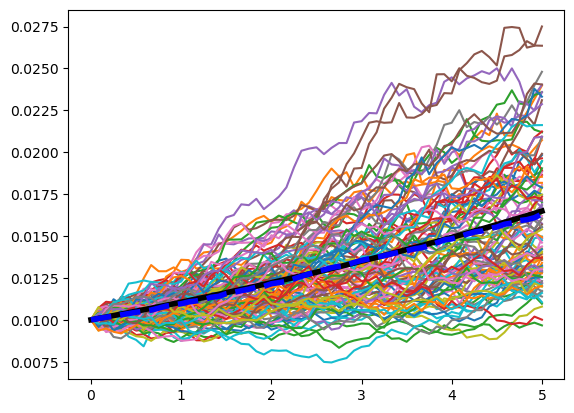

In [4]:
# Plot paths
n = 100
S_ = S.iloc[:n, :]

for path in S_.index:
    plt.plot(S_.loc[path, simulationGrid])
    
# E[S(t)] = S(0) * exp^{r * t}
mean = S0 * np.exp(r * simulationGrid)
plt.plot(simulationGrid, mean, linewidth = 4, color = "black") # Theoretical mean
sampleMean = [np.mean(S_.loc[:, t]) for t in simulationGrid]
plt.plot(simulationGrid, sampleMean, linewidth = 4, linestyle = '--', color = "blue") # Theoretical mean

### Cashflows Without Exercise

In [5]:
# Calculate CashFlows (this is "CashFlow Matrix" used at each regression step)
def CalculateCashflowsWithoutExercise():
    if contract == "Swap":
        CashflowsWithoutExercise = pd.DataFrame(index = S.index, columns = cfGrid)
        for t in cfGrid:
            CashflowsWithoutExercise.loc[:, t] = notional * (S.loc[:, t] - fixedRate)
    elif contract == "American Put":
        CashflowsWithoutExercise = pd.DataFrame(index = S.index, columns = cfGrid)
    return CashflowsWithoutExercise

CashflowsWithoutExercise = CalculateCashflowsWithoutExercise()
CashflowsWithoutExercise

,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00
0,-232.060917,-230.706626,-191.123818,-140.926311,-82.534895,34.970905,-69.484803,20.563279,11.530888,-26.9351,-14.324811,138.953934,96.284011,91.297667,158.521728,313.397113,367.824723,477.443945,497.258797,555.602705
1,-290.398788,-177.926012,-40.268279,-44.170297,71.971528,136.458176,240.883088,254.353926,315.872821,438.897317,526.234853,531.438469,471.105617,653.95014,477.185333,695.302717,753.804757,900.408425,835.587863,1067.340463
2,-337.8334,-368.239797,-361.152617,-391.947548,-431.939182,-416.002072,-400.865705,-449.587139,-422.543817,-397.16491,-351.668399,-352.096471,-368.809285,-349.23187,-389.753534,-388.397257,-373.495643,-303.198025,-266.501817,-234.167284
3,-283.62709,-196.964418,-94.064991,-69.477494,-30.775249,19.623756,-27.887907,44.353323,14.542937,133.90597,131.897401,32.394388,181.580141,209.336689,311.476104,233.045398,484.513239,573.730676,559.875983,760.938257
4,-276.910019,-254.755632,-305.716677,-70.783928,18.843039,123.918931,155.636648,197.730364,323.514888,328.583895,297.236276,439.304468,257.579041,257.009804,240.139789,288.333884,255.180554,242.661456,320.307542,244.505692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-319.702922,-373.727838,-275.311577,-238.188743,-197.242234,-145.265345,-177.367649,-186.516555,-182.768644,-250.822197,-313.052452,-176.796229,-235.529195,-238.48397,-137.904228,-33.81785,-120.949815,-179.425483,-194.217498,-72.167285
996,-393.630737,-319.158524,-307.363475,-353.226982,-324.103077,-269.474398,-163.81289,-138.654671,-187.607129,-153.050874,-136.681183,-129.506891,-75.963868,-8.507412,107.467537,102.177538,114.731038,119.778749,10.232749,43.147384
997,-260.245716,-337.921898,-277.558269,-253.737515,-149.581798,-119.910157,-143.18673,-171.720424,-149.061247,-164.590248,-70.828473,-184.106359,-188.500009,-258.701658,-239.625637,-137.728569,-100.440637,-31.515184,-30.772064,65.793296
998,-392.983883,-314.983458,-286.390321,-313.974129,-330.745262,-279.085884,-274.213809,-339.936971,-323.946483,-402.619005,-392.848076,-393.464325,-408.649171,-332.314172,-268.977011,-282.465396,-330.797026,-358.619417,-291.742945,-316.371994


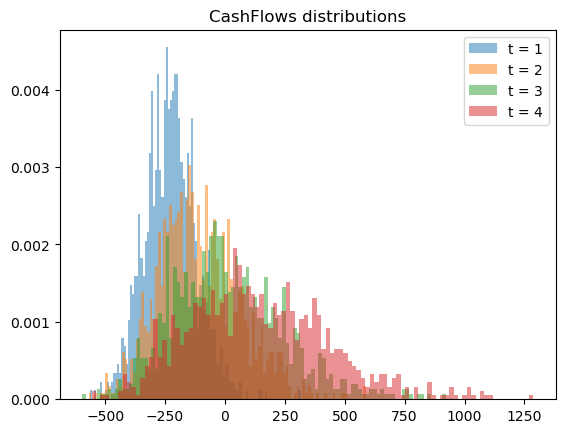

In [6]:
# Plot Cashflows
if CashflowsWithoutExercise.shape[1] != 0:
    for year in yearlyGrid:
        if year not in cfGrid: continue
        plt.hist(CashflowsWithoutExercise.loc[:, year], bins = 100, density = True, label = f"t = {year}", alpha = 0.5)
    plt.title("CashFlows distributions")
    plt.legend()

### Realized Future Cashflows


In [7]:
RFC = pd.DataFrame(index = CashflowsWithoutExercise.index, columns = CashflowsWithoutExercise.columns)
for path in RFC.index:
    for t in RFC.columns:
        RFC.at[path, t] = CashflowsWithoutExercise.loc[path, [time for time in CashflowsWithoutExercise.columns if time > t]].sum() # Cashflows AFTER t
RFC

,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00
0,2007.61333,2238.319956,2429.443774,2570.370084,2652.904979,2617.934074,2687.418878,2666.855599,2655.324711,2682.25981,2696.584622,2557.630688,2461.346677,2370.049009,2211.527282,1898.130169,1530.305446,1052.861501,555.602705,0
1,8108.430903,8286.356915,8326.625194,8370.795491,8298.823963,8162.365788,7921.4827,7667.128775,7351.255954,6912.358636,6386.123784,5854.685315,5383.579698,4729.629558,4252.444225,3557.141508,2803.336751,1902.928326,1067.340463,0
2,-7016.762373,-6648.522576,-6287.369959,-5895.422411,-5463.483229,-5047.481157,-4646.615453,-4197.028313,-3774.484496,-3377.319586,-3025.651187,-2673.554716,-2304.745431,-1955.513561,-1565.760027,-1177.362769,-803.867126,-500.669101,-234.167284,0
3,3272.044203,3469.008621,3563.073612,3632.551106,3663.326355,3643.702599,3671.590506,3627.237183,3612.694245,3478.788276,3346.890875,3314.496487,3132.916346,2923.579657,2612.103553,2379.058155,1894.544916,1320.81424,760.938257,0
4,3359.230035,3613.985667,3919.702344,3990.486272,3971.643233,3847.724302,3692.087654,3494.35729,3170.842402,2842.258506,2545.02223,2105.717762,1848.138722,1591.128918,1350.989129,1062.655245,807.474691,564.813234,244.505692,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-3729.554789,-3355.826951,-3080.515374,-2842.326631,-2645.084396,-2499.819052,-2322.451402,-2135.934848,-1953.166203,-1702.344006,-1389.291554,-1212.495325,-976.96613,-738.48216,-600.577932,-566.760082,-445.810267,-266.384784,-72.167285,0
996,-2069.57638,-1750.417856,-1443.054381,-1089.827399,-765.724321,-496.249923,-332.437034,-193.782362,-6.175233,146.87564,283.556823,413.063715,489.027583,497.534995,390.067458,287.88992,173.158882,53.380133,43.147384,0
997,-2943.693579,-2605.77168,-2328.213411,-2074.475897,-1924.894098,-1804.983941,-1661.797212,-1490.076788,-1341.015541,-1176.425293,-1105.596819,-921.490461,-732.990452,-474.288794,-234.663158,-96.934589,3.506048,35.021232,65.793296,0
998,-6242.144855,-5927.161397,-5640.771076,-5326.796947,-4996.051685,-4716.965801,-4442.751992,-4102.815021,-3778.868537,-3376.249532,-2983.401456,-2589.937132,-2181.28796,-1848.973789,-1579.996778,-1297.531382,-966.734356,-608.114939,-316.371994,0


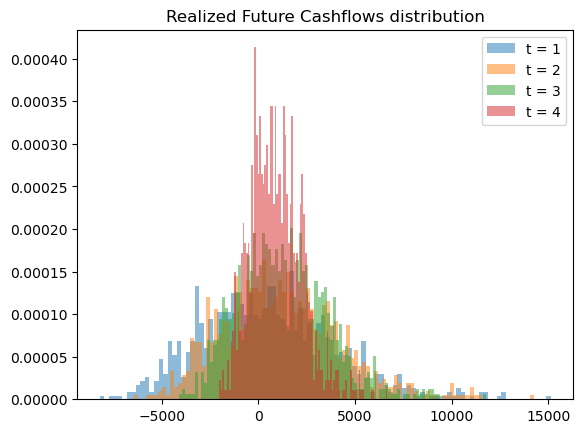

In [8]:
# Plot 
for year in yearlyGrid:
    if year not in cfGrid: continue
    plt.hist(RFC.loc[:, year], bins = 100, density = True, label = f"t = {year}", alpha = 0.5)
plt.title(f"Realized Future Cashflows distribution")
plt.legend()
plt.show()


### Cashflows If Exercise

In [9]:
# Exercise Payoff
def Payoff(path, t):
    if contract == "American Put":
        return max(K - S.at[path, t], 0)
    else:
        raise Exception("Contract {contract} not recognized!")

def CalculateCashflowsIfExercise():
    cashflowsIfExercise = pd.DataFrame(0, index = paths, columns = exerciseGrid)
    for t in exerciseGrid:
        for path in paths:
            cashflowsIfExercise.at[path, t] = Payoff(path, t)
    return cashflowsIfExercise

E = pd.DataFrame(0, index = paths, columns = exerciseGrid) # To store exercise indicators

CashflowsIfExercise = CalculateCashflowsIfExercise()
CashflowsIfExercise

""
0
1
2
3
4
...
995
996
997
998


### Regression

In [10]:
def GetCashflowsStricklyBetweenDates(now, next):
    cashflows = CashflowsWithoutExercise.loc[:, [t for t in CashflowsWithoutExercise.columns if t < next and t > now]]
    cashflowValues = cashflows.sum(axis = 1)
    return list(cashflowValues)


def GetCashflowValuesPaidOnDate(now):
    cashflows = CashflowsWithoutExercise.loc[:, [t for t in CashflowsWithoutExercise.columns if t == now]]
    cashflowValues = cashflows.sum(axis = 1)
    return list(cashflowValues)


def AddObservables(data, t):
    for observable in observables:
        if observable == "S":
            data[observable] = S.loc[:, t]
        else:
            raise Exception(f"Observable {observable} not recognized!")
    return data


def GetRegressionFormula(data):
    assert "Y" in data.columns, "Y must be provided!"
    formula = 'Y ~ '
    for observable in observables:
        for order in range(1, polynomialOrder + 1):
            if order == 1:
                formula += observable
            else:
                formula += f" + I({observable} ** {order})"
    return formula
    

def Regress(data):
    formula = GetRegressionFormula(data)
    # Make sure that data is of numeric (not object) type
    for column in data.columns:
        data[column] = pd.to_numeric(data[column])
    model = smf.ols(formula = formula, data = data)
    fit = model.fit()
    predict = fit.predict(data)
    return predict
    
    
def ComputeNextContinuationValue(now, next):
    Y = [0 for path in paths]
    if algorithm == "LS":
        Y = GetCashflowsStricklyBetweenDates(now, 99) # All cashflows after now
    else: 
        # TvR
        if next in Distributions.columns:
            Y = [y + v for (y, v) in zip(Y, Distributions.loc[:, next])] # Skip discounting
        cashFlowsBetween = GetCashflowsStricklyBetweenDates(now, next)
        Y = [y + cfBetween for (y, cfBetween) in zip(Y, cashFlowsBetween)]
        
    Ct = GetCashflowValuesPaidOnDate(now) # Don't regress, but contribute to the value
    if RegressOnDateNowCashflows:
        Y = [y + cf for (y, cf) in zip(Y, Ct)]
        
    # X & Y for regression
    data = pd.DataFrame(index = paths, columns = ["Y"])
    data["Y"] = Y
    # Observables
    data = AddObservables(data, now)
        
    # Do regression
    regressionResult = Regress(data)
    contVal = regressionResult.copy()
    if not RegressOnDateNowCashflows:
        contVal = [cv + cf for (cv, cf) in zip(contVal, Ct)]
        
    return contVal
    
    
def UpdateCashFlowMatrixAndDistributions():
    for path in paths:
        if E.at[path, now] == 1:
            E.loc[path, [t for t in E.columns if t > now]] = 0
            CashflowsWithoutExercise.loc[path, now] = exerV[path]
            CashflowsWithoutExercise.loc[path, [t for t in CashflowsWithoutExercise.columns if t > now]] = 0
            Distributions.loc[path, [t for t in Distributions.columns if t > now]] = 0
    


In [11]:
# Regression
Distributions = pd.DataFrame(index = paths)

regressionDates = list(valuationGrid[1:]).copy() # Day-0 is not regression date
regressionDatesCount = len(regressionDates)
for i in range(regressionDatesCount - 1, -1, -1): # Backward induction
    now = regressionDates[i]
    next = regressionDates[i + 1] if i + 1 != regressionDatesCount else now + 1 # Add 1Y to last regresson date
    contV = ComputeNextContinuationValue(now, next)
    if isCallable and now in exerciseGrid:
        exerV = list(CashflowsIfExercise.loc[:, now])
        E.loc[:, now] = [1 if exerV[path] > contV[path] else 0 for path in paths]
        # Compare Continuation Value with exercise payoff
        V = [exerV[path] if E.at[path, now] == 1 else contV[path] for path in paths]
        UpdateCashFlowMatrixAndDistributions()
    else:
        V = contV
    Distributions.loc[:, now] = V
    
Distributions.loc[:, 0] = np.mean(Distributions.loc[:, now])

In [12]:
# V = pd.DataFrame(distribution)
Distributions = Distributions[Distributions.columns[::-1]]
Distributions

,0.000000,0.083333,0.166667,0.250000,0.333333,0.416667,0.500000,0.583333,0.666667,0.750000,...,4.250000,4.333333,4.416667,4.500000,4.583333,4.666667,4.750000,4.833333,4.916667,5.000000
0,-512.995676,607.345175,946.589829,1465.522331,1584.066296,1715.857997,881.356336,1117.778170,534.650625,1425.716820,...,1733.257273,1248.039176,1327.450928,1570.642669,1151.538635,1130.743049,1033.996857,530.867963,551.338863,555.602705
1,-512.995676,571.221353,202.353450,-143.915513,-289.525346,872.282535,1909.749174,3596.362405,5160.788661,4560.346951,...,3365.763794,2682.618880,2547.755501,2885.441314,1656.085562,1622.024501,1729.922566,953.092722,1016.663425,1067.340463
2,-512.995676,-897.207184,-887.397381,-1487.698967,-1178.657148,-1375.407143,-2259.932893,-2898.311307,-2346.110370,-2371.322292,...,-1365.496791,-964.743918,-840.787913,-817.042445,-518.787714,-550.611921,-493.644990,-204.542148,-179.158951,-234.167284
3,-512.995676,634.701879,1710.520616,45.349727,444.013149,1008.892753,1550.127189,1939.013053,3249.130557,3467.770009,...,2225.413778,1816.895021,1677.926071,1868.648603,1254.801810,1225.014540,1161.907591,617.866274,643.289747,760.938257
4,-512.995676,186.906696,215.103363,232.453443,20.032219,1682.196123,380.197110,589.838260,166.287902,-1102.601911,...,1259.292078,807.072798,781.967082,847.218025,581.974705,692.363242,674.715643,271.217122,287.114266,244.505692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-512.995676,-62.220311,-1052.596971,-970.355597,-725.095106,-2358.486736,-2399.121839,-1721.848361,-1580.571547,-419.372945,...,-315.259481,-248.892360,-315.559870,-441.841280,-352.603870,-287.662199,-351.640583,-112.753182,-86.357992,-72.167285
996,-512.995676,-788.408385,-2411.482971,-3108.742031,-2092.917548,-1689.621398,-1062.351538,-752.909434,-399.219843,-1139.862314,...,669.891924,388.329286,577.504060,470.407790,258.949044,120.146383,52.922716,83.539091,55.946049,43.147384
997,-512.995676,368.456022,405.004335,693.907420,-1170.966859,-1170.071224,-1510.146001,-869.824368,579.711911,-469.551938,...,-229.724274,-85.017042,-91.643303,8.197011,-24.714171,-12.495144,-28.562396,-25.729332,10.160123,65.793296
998,-512.995676,-1135.539129,-1822.159948,-3089.699498,-3010.629944,-1490.824431,-964.400902,-935.872639,-872.650178,-667.285870,...,-1188.323431,-989.937379,-1053.299676,-984.633693,-539.865310,-588.054837,-543.104986,-284.642995,-346.775126,-316.371994


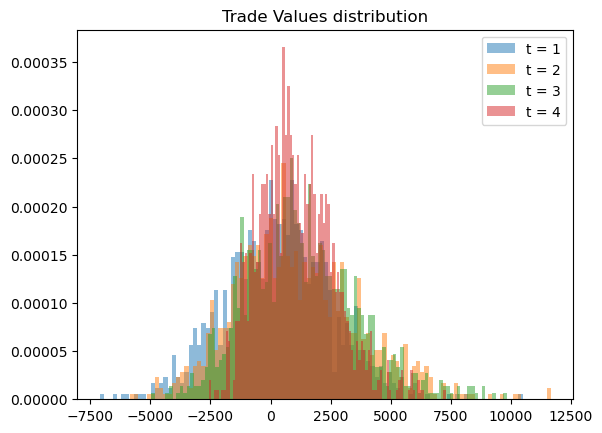

In [13]:
# Plot
for year in yearlyGrid:
    if year not in valuationGrid or year == 0: continue
    plt.hist(Distributions.loc[:, year], bins = 100, density = True, label = f"t = {year}", alpha = 0.5)
plt.title(f"Trade Values distribution")
plt.legend()
plt.show()


### Risk Profiles

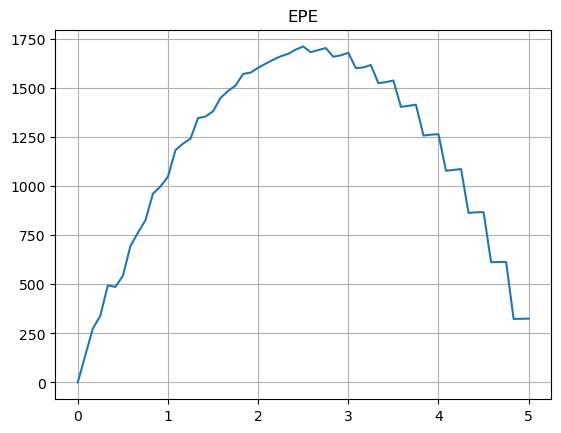

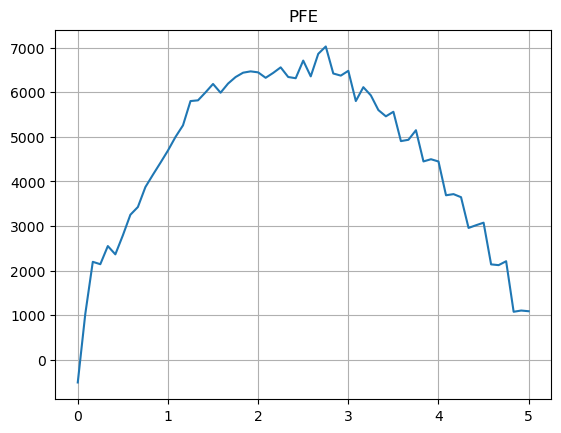

In [14]:
# Profiles
q = 0.975

def EPE(V):
    VPlus = Distributions.applymap(lambda x: max(x, 0))
    profile = VPlus.mean(axis = 0)
    return profile

def PFE(V):
    profile = Distributions.apply(lambda x: np.quantile(x, q)) 
    return profile


EPE = EPE(V)
plt.plot(EPE.index, EPE.values)
plt.title("EPE")
plt.grid()
plt.show()

PFE = PFE(V)
plt.plot(PFE.index, PFE.values)
plt.title("PFE")
plt.grid()
plt.show()

In [15]:
# Checks (for callable products with cash settlement!)
if isCallable:
    # One exercise only
    assert all([x <= 1 for x in E.sum(axis = 1)])
    # Distributions are empty after exercise time
    for path in paths:
        exerTime = __builtin__.next(iter([t for t in E.loc[path].index if E.at[path, t] == 1]), 99)
        d = Distributions.loc[path, [t for t in Distributions.columns if t > exerTime]]
        assert d.sum() == 0
            